# Modelling Fresh Water Fish Stock

About the dataset: 

This demonstration uses public data collected from the UK Environment Agency on Fresh Water survey statistics. Here we use the population count data for 4 sites in Devon, South West England.

Samples are taken from rivers and lakes in the:
- Dart
- Exe
- Teign
- Plym

We'll use count regression models to estimate population counts based on factors such as species, month of year, location, etc.

This demonstration shows how OCI Data Science Notebooks can be used to:
- load conda environments
- install additional dependencies
- integrate with git
- accelerate data science tasks with ADS
- deploy models to endpoints
- score endpoints via REST

## Load Dependencies

Using OCI Data Science we have the option to install additional dependencies either via the terminal, or via the Jupyter Notebook cells. Packages can be installed into pre-build Conda environments, though you may need to build a custom conda environment for running OCI Data Science Jobs with additional packages.

In [1]:
!pip install bambi

  Using cached bambi-0.15.0-py3-none-any.whl.metadata (8.8 kB)
  Using cached arviz-0.21.0-py3-none-any.whl.metadata (8.8 kB)
  Using cached formulae-0.5.4-py3-none-any.whl.metadata (4.5 kB)
  Using cached pymc-5.21.1-py3-none-any.whl.metadata (16 kB)
  Using cached xarray-2025.3.1-py3-none-any.whl.metadata (12 kB)
  Using cached h5netcdf-1.6.1-py3-none-any.whl.metadata (13 kB)
  Using cached xarray_einstats-0.8.0-py3-none-any.whl.metadata (5.8 kB)
  Using cached pytensor-2.28.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.9 kB)
  Using cached h5py-3.13.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.5 kB)
  Using cached etuples-0.3.9-py3-none-any.whl
  Using cached logical_unification-0.4.6-py3-none-any.whl
  Using cached miniKanren-1.0.3-py3-none-any.whl
  Using cached cons-0.4.6-py3-none-any.whl
  Using cached toolz-1.0.0-py3-none-any.whl.metadata (5.1 kB)
  Using cached multipledispatch-1.0.0-py3-none-any.whl.metadata (3.8 kB)
Usin

In [2]:
!pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


In [13]:
!pip install oracle-ads[data]==2.13.0

  Using cached datefinder-0.7.3-py2.py3-none-any.whl.metadata (3.0 kB)
  Using cached fastavro-1.10.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.5 kB)
  Using cached htmllistparse-0.6.1-py3-none-any.whl.metadata (2.6 kB)
  Using cached openpyxl-3.1.5-py2.py3-none-any.whl.metadata (2.5 kB)
  Using cached pandavro-1.8.0-py3-none-any.whl.metadata (8.5 kB)
  Using cached SQLAlchemy-1.4.46-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (10 kB)
  Using cached regex-2024.11.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (40 kB)
  Using cached fusepy-3.0.1-py3-none-any.whl
  Using cached html5lib-1.1-py2.py3-none-any.whl.metadata (16 kB)
  Using cached et_xmlfile-2.0.0-py3-none-any.whl.metadata (2.7 kB)
  Using cached greenlet-3.1.1-cp311-cp311-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl.metadata (3.8 kB)
Using cached datefinder-0.7.3-py2.py3-none-any.whl (10 kB)
Using cached fast

In [283]:
import ads
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import bambi as bmb
import os
from ads.dataset.dataset import ADSDataset
from ads.dataset.factory import DatasetFactory
from sklearn.model_selection import train_test_split
import arviz as az
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


In [284]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data

The data is stored on a Git repository. We connected to the repository at the time of creating the notebook session. We're able to pull the CSV data into a single dataframe quickly using Python.

In [285]:
files = os.listdir('repos/HarrySnart/FWFishStock.git')

files

['River_Teign_FW_Counts_2015_2025.csv',
 'River_Plym_FW_Counts_2015_2025.csv',
 'README.md',
 '.git',
 '.ipynb_checkpoints',
 'River_Dart_FW_Counts_2015_2025.csv',
 'River_Exe_FW_Counts_2015_2025.csv']

In [286]:
data = pd.read_csv('repos/HarrySnart/FWFishStock.git/' + files[0])

print(data.shape)

(200, 39)


In [287]:
for i in [1,2,3,4,5,6]:
    try:
        dat = pd.read_csv('repos/HarrySnart/FWFishStock.git/'+files[i])
        data = pd.concat([data,dat])
    except:
        continue

In [9]:
print(data.shape)

(1674, 40)


In [288]:
data.head()

,AREA,SITE_ID,SITE_NAME,SURVEY_ID,EVENT_DATE,EVENT_DATE_YEAR,SAMPLE_CODE,SURVEY_RANKED_NGR,SURVEY_RANKED_EASTING,SURVEY_RANKED_NORTHING,...,SPCSNO_SE,SPCSPV,SPCSPV_SE,OBSERVED_ABUNDANCE,ZERO_CATCH,SURVEY_STATUS,IS_THIRD_PARTY,IS_SPECIES_SELECTIVE,SURVEY_INSERT_DATE,# FWFishStock
0,Teign,9242.0,Leigh House (Te),148895.0,10/08/2016,2016.0,NaN,SX6827087990,268270.0,87990.0,...,NaN,NaN,NaN,NaN,No,Completed,No,No,11/08/2016,NaN
1,Teign,9242.0,Leigh House (Te),148895.0,10/08/2016,2016.0,NaN,SX6827087990,268270.0,87990.0,...,NaN,NaN,NaN,NaN,No,Completed,No,No,11/08/2016,NaN
2,Teign,9242.0,Leigh House (Te),153015.0,02/08/2018,2018.0,NaN,SX6827087990,268270.0,87990.0,...,NaN,NaN,NaN,NaN,No,Completed,No,No,10/08/2018,NaN
3,Teign,9242.0,Leigh House (Te),153015.0,02/08/2018,2018.0,NaN,SX6827087990,268270.0,87990.0,...,NaN,NaN,NaN,NaN,No,Completed,No,No,10/08/2018,NaN
4,Teign,9242.0,Leigh House (Te),153015.0,02/08/2018,2018.0,NaN,SX6827087990,268270.0,87990.0,...,NaN,NaN,NaN,NaN,No,Completed,No,No,10/08/2018,NaN


In [289]:
data = data[['AREA', 'SITE_ID', 'SITE_NAME', 'SURVEY_ID', 'EVENT_DATE',
       'EVENT_DATE_YEAR', 'SAMPLE_CODE', 'SURVEY_RANKED_NGR',
       'SURVEY_RANKED_EASTING', 'SURVEY_RANKED_NORTHING', 'SURVEY_LENGTH',
       'SURVEY_WIDTH', 'SURVEY_AREA', 'FISHED_WIDTH', 'FISHED_AREA',
       'SURVEY_METHOD', 'SURVEY_STRATEGY', 'NO_OF_RUNS', 'SURVEY_SPECIES_ID',
       'SPECIES_ID', 'SPECIES_NAME', 'LATIN_NAME', 'RUN1', 'RUN2', 'RUN3',
       'RUN4', 'RUN5', 'RUN6', 'ALL_RUNS', 'SPCSNO', 'SPCSNO_SE', 'SPCSPV',
       'SPCSPV_SE', 'OBSERVED_ABUNDANCE', 'ZERO_CATCH', 'SURVEY_STATUS',
       'IS_THIRD_PARTY', 'IS_SPECIES_SELECTIVE']]

## Explore Data

Whilst we have got popular open-source packages like Seaborn and Matplotlib installed, we can accelerate the Exploratory Data Analysis phase by using the ADS package. Other features of ADS include feature selection and model tuning. We also have the automlx package that allows us to quickly create predictive models using AutoML

In [290]:
eda = ADSDataset.from_dataframe(data)

In [291]:
eda.show_in_notebook()

Accordion(children=(HTML(value='<h3>Type: ADSDataset</h3><h3>1,674 Rows, 38 Columns</h3><h4>Column Types:</h4>…

## Prepare Data

Here we do some simple feature engineering such as:
- get the month from the survey date
- get the season from the month
- group the species
- log transform the target variable

In [292]:
data=data.reset_index()

In [293]:
fish = data[['AREA', 'SITE_NAME', 'EVENT_DATE',
       'EVENT_DATE_YEAR', 
       'SURVEY_RANKED_EASTING', 'SURVEY_RANKED_NORTHING', 'FISHED_AREA',
       'SURVEY_METHOD', 'SURVEY_STRATEGY', 'NO_OF_RUNS', 'SPECIES_NAME', 'ALL_RUNS']]

In [294]:
fish['Observed'] = fish['ALL_RUNS']/fish['NO_OF_RUNS']
fish['SURVEY_METHOD_STRATEGY'] = fish['SURVEY_METHOD'] + '/'+ fish['SURVEY_STRATEGY']

In [295]:
month = []

for i in range(len(fish)):
    try:
        dt = fish['EVENT_DATE'].loc[i]
        mth = int(dt.split('/')[1])
        month.append(mth)
    except:
        print('issue at index:',i)
#fish['MONTH'] = month

issue at index: 331


In [296]:
fish.loc[330:332]

,AREA,SITE_NAME,EVENT_DATE,EVENT_DATE_YEAR,SURVEY_RANKED_EASTING,SURVEY_RANKED_NORTHING,FISHED_AREA,SURVEY_METHOD,SURVEY_STRATEGY,NO_OF_RUNS,SPECIES_NAME,ALL_RUNS,Observed,SURVEY_METHOD_STRATEGY
330,Plym,U/S Dewerstone,27/07/2023,2023.0,253116.0,64309.0,122.88,DC ELECTRIC FISHING,CATCH PUE/T SAMPLE,1.0,Brown / sea trout,11.0,11.0,DC ELECTRIC FISHING/CATCH PUE/T SAMPLE
331,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
332,Dart,U/s Postbridge (Te),30/07/2015,2015.0,264620.0,79010.0,429.68,DC ELECTRIC FISHING,SINGLE CATCH SAMPLE,1.0,Brown / sea trout,53.0,53.0,DC ELECTRIC FISHING/SINGLE CATCH SAMPLE


In [297]:
fish = fish.drop([331])

In [298]:
fish = fish.reset_index()

In [299]:
month = []

for i in range(len(fish)):
    try:
        dt = fish['EVENT_DATE'].loc[i]
        mth = int(dt.split('/')[1])
        month.append(mth)
    except:
        print('issue at index:',i)

In [300]:
fish['EVENT_MONTH'] = month

In [301]:
fish.head()

,index,AREA,SITE_NAME,EVENT_DATE,EVENT_DATE_YEAR,SURVEY_RANKED_EASTING,SURVEY_RANKED_NORTHING,FISHED_AREA,SURVEY_METHOD,SURVEY_STRATEGY,NO_OF_RUNS,SPECIES_NAME,ALL_RUNS,Observed,SURVEY_METHOD_STRATEGY,EVENT_MONTH
0,0,Teign,Leigh House (Te),10/08/2016,2016.0,268270.0,87990.0,518.0,ELECTRIC FISHING,SINGLE CATCH SAMPLE,1.0,Atlantic salmon,60.0,60.0,ELECTRIC FISHING/SINGLE CATCH SAMPLE,8
1,1,Teign,Leigh House (Te),10/08/2016,2016.0,268270.0,87990.0,518.0,ELECTRIC FISHING,SINGLE CATCH SAMPLE,1.0,Brown / sea trout,85.0,85.0,ELECTRIC FISHING/SINGLE CATCH SAMPLE,8
2,2,Teign,Leigh House (Te),02/08/2018,2018.0,268270.0,87990.0,522.9,ELECTRIC FISHING,SINGLE CATCH SAMPLE,1.0,European eels > elvers,2.0,2.0,ELECTRIC FISHING/SINGLE CATCH SAMPLE,8
3,3,Teign,Leigh House (Te),02/08/2018,2018.0,268270.0,87990.0,522.9,ELECTRIC FISHING,SINGLE CATCH SAMPLE,1.0,Atlantic salmon,154.0,154.0,ELECTRIC FISHING/SINGLE CATCH SAMPLE,8
4,4,Teign,Leigh House (Te),02/08/2018,2018.0,268270.0,87990.0,522.9,ELECTRIC FISHING,SINGLE CATCH SAMPLE,1.0,Brown / sea trout,113.0,113.0,ELECTRIC FISHING/SINGLE CATCH SAMPLE,8


In [302]:
winter = []
spring = []
summer = []
autumn = []

for i in range(len(fish)):
    wi = pd.Series([12,1,2])
    sp = pd.Series([3,4,5])
    sm = pd.Series([6,7,8])
    au = pd.Series([9,10,11])
    if pd.Series(fish['EVENT_MONTH'].loc[i]).isin(wi).any():
        winter.append(1)
        spring.append(0)
        summer.append(0)
        autumn.append(0)
    if pd.Series(fish['EVENT_MONTH'].loc[i]).isin(sp).any():
        winter.append(0)
        spring.append(1)
        summer.append(0)
        autumn.append(0)
    if pd.Series(fish['EVENT_MONTH'].loc[i]).isin(sm).any():
        winter.append(0)
        spring.append(0)
        summer.append(1)
        autumn.append(0)
    if pd.Series(fish['EVENT_MONTH'].loc[i]).isin(au).any():
        winter.append(0)
        spring.append(0)
        summer.append(0)
        autumn.append(1)

In [303]:
len(winter) == len(summer) == len(autumn) == len(spring) == len(fish)

True

In [304]:
fish['SEASON_WINTER'] = winter
fish['SEASON_SPRING'] = spring
fish['SEASON_SUMMER'] = summer
fish['SEASON_AUTUMN'] = autumn

In [305]:
fish.head()

,index,AREA,SITE_NAME,EVENT_DATE,EVENT_DATE_YEAR,SURVEY_RANKED_EASTING,SURVEY_RANKED_NORTHING,FISHED_AREA,SURVEY_METHOD,SURVEY_STRATEGY,NO_OF_RUNS,SPECIES_NAME,ALL_RUNS,Observed,SURVEY_METHOD_STRATEGY,EVENT_MONTH,SEASON_WINTER,SEASON_SPRING,SEASON_SUMMER,SEASON_AUTUMN
0,0,Teign,Leigh House (Te),10/08/2016,2016.0,268270.0,87990.0,518.0,ELECTRIC FISHING,SINGLE CATCH SAMPLE,1.0,Atlantic salmon,60.0,60.0,ELECTRIC FISHING/SINGLE CATCH SAMPLE,8,0,0,1,0
1,1,Teign,Leigh House (Te),10/08/2016,2016.0,268270.0,87990.0,518.0,ELECTRIC FISHING,SINGLE CATCH SAMPLE,1.0,Brown / sea trout,85.0,85.0,ELECTRIC FISHING/SINGLE CATCH SAMPLE,8,0,0,1,0
2,2,Teign,Leigh House (Te),02/08/2018,2018.0,268270.0,87990.0,522.9,ELECTRIC FISHING,SINGLE CATCH SAMPLE,1.0,European eels > elvers,2.0,2.0,ELECTRIC FISHING/SINGLE CATCH SAMPLE,8,0,0,1,0
3,3,Teign,Leigh House (Te),02/08/2018,2018.0,268270.0,87990.0,522.9,ELECTRIC FISHING,SINGLE CATCH SAMPLE,1.0,Atlantic salmon,154.0,154.0,ELECTRIC FISHING/SINGLE CATCH SAMPLE,8,0,0,1,0
4,4,Teign,Leigh House (Te),02/08/2018,2018.0,268270.0,87990.0,522.9,ELECTRIC FISHING,SINGLE CATCH SAMPLE,1.0,Brown / sea trout,113.0,113.0,ELECTRIC FISHING/SINGLE CATCH SAMPLE,8,0,0,1,0


In [306]:
eda2 = ADSDataset.from_dataframe(fish)

In [307]:
eda2.show_in_notebook()

Accordion(children=(HTML(value='<h3>Type: ADSDataset</h3><h3>1,673 Rows, 20 Columns</h3><h4>Column Types:</h4>…

In [308]:
fish.groupby('SPECIES_NAME')['Observed'].count()

SPECIES_NAME
3-spined stickleback         15
Atlantic salmon             293
Brook lamprey ammocoetes      1
Brown / sea trout           411
Bullhead                    261
Chub                          1
Dace                          1
European eel                 16
European eels > elvers      152
European elvers              19
Flounder                      3
Grayling                     16
Gudgeon                       2
Lampetra sp.                  2
Lamprey sp.                 117
Lamprey sp. ammocoetes        4
Minnow                      173
Perch                         1
Pike                          1
Rainbow trout                 2
Roach                         2
Stone loach                 180
Name: Observed, dtype: int64

In [309]:
drop_sp = pd.Series(['Atlantic salmon','Chub','Dace','Flounder','Gudgeon','Perch','Pike','Rainbow trout','Roach','3-spined stickleback','Grayling'])
merge_l = pd.Series(['Lampetra sp.','Lamprey sp.','Lamprey sp. ammocoetes','Brook lamprey ammocoetes'])
merge_e = pd.Series(['European eel','European eels > elvers','European elvers'])

names_clean = []

for i in range(len(fish)):
    name = fish['SPECIES_NAME'].loc[i]
    if pd.Series(fish['SPECIES_NAME'].loc[i]).isin(drop_sp).any():
        name = 'Other'
    if pd.Series(fish['SPECIES_NAME'].loc[i]).isin(merge_l).any():
        name='Lamprey'
    if pd.Series(fish['SPECIES_NAME'].loc[i]).isin(merge_e).any():
        name='European Eel'
    names_clean.append(name)
    

In [310]:
len(names_clean)==len(fish)

True

In [311]:
fish['SPECIES'] = names_clean

In [312]:
fish.groupby('SPECIES')['index'].count()

SPECIES
Brown / sea trout    411
Bullhead             261
European Eel         187
Lamprey              124
Minnow               173
Other                337
Stone loach          180
Name: index, dtype: int64

In [313]:
fish_model = fish[['AREA','EVENT_DATE_YEAR',
       'SURVEY_RANKED_EASTING', 'SURVEY_RANKED_NORTHING', 'FISHED_AREA', 'SPECIES', 'Observed', 'SURVEY_METHOD_STRATEGY', 'SEASON_SUMMER', 'SEASON_AUTUMN']]

In [314]:
eda3 = ADSDataset.from_dataframe(fish_model)

In [315]:
eda3.show_in_notebook()

Accordion(children=(HTML(value='<h3>Type: ADSDataset</h3><h3>1,673 Rows, 10 Columns</h3><h4>Column Types:</h4>…

## Feature Engineering

Here we do typical pre-processing of modelling data such as:
- one-hot-encoding categorical variables
- standard scaling (i.e. normalisation) of numeric variables

In [41]:
X = fish_model[['AREA','EVENT_DATE_YEAR',
       'SURVEY_RANKED_EASTING', 'SURVEY_RANKED_NORTHING', 'FISHED_AREA', 'SPECIES', 'SURVEY_METHOD_STRATEGY', 'SEASON_SUMMER', 'SEASON_AUTUMN']]
y = fish_model['Observed']

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=X['SPECIES'],test_size=0.2)

In [43]:
def preprocess_data(x_train,x_test,y_train,y_test, categorical_features, numerical_features, target_variable):
    """
    Preprocesses categorical and numerical features using scikit-learn.

    Args:
        data (pd.DataFrame): The input DataFrame.
        categorical_features (list): List of categorical column names.
        numerical_features (list): List of numerical column names.
        target_variable (str): The name of the target variable.

    Returns:
        tuple: A tuple containing the preprocessor and the transformed data.
    """

    # Create transformers - train
    numerical_transformer = StandardScaler()
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')

    # Create column transformer - train
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    # Fit and transform the data - train
    X_transformed = preprocessor.fit_transform(x_train)

    # Get the transformed feature names - train
    categorical_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
    all_feature_names = numerical_features + list(categorical_names)

    # Create a DataFrame with transformed features - train
    X_transformed_df = pd.DataFrame(X_transformed, columns=all_feature_names)
    X_transformed_df[target_variable] = y_train #add target back in.
    train_out = X_transformed_df.copy()
    
    # Create transformers - test
    numerical_transformer = StandardScaler()
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')

    # Create column transformer - test
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    # Fit and transform the data - test
    X_transformed = preprocessor.fit_transform(x_test)

    # Get the transformed feature names - test
    categorical_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
    all_feature_names = numerical_features + list(categorical_names)

    # Create a DataFrame with transformed features - test
    X_transformed_df = pd.DataFrame(X_transformed, columns=all_feature_names)
    X_transformed_df[target_variable] = y_test #add target back in.
    test_out = X_transformed_df.copy()

    return train_out,test_out



In [44]:

# 'SEASON_SUMMER', 'SEASON_AUTUMN'
categorical_features = ['AREA', 'SPECIES','SURVEY_METHOD_STRATEGY']
numerical_features = ['EVENT_DATE_YEAR','SURVEY_RANKED_EASTING', 'SURVEY_RANKED_NORTHING', 'FISHED_AREA']
target_variable = 'Observed'

# Preprocess the entire dataset
train, test = preprocess_data(X_train,X_test,y_train,y_test, categorical_features, numerical_features, target_variable)



In [45]:
train['SEASON_SUMMER'] = X_train['SEASON_SUMMER']
train['SEASON_AUTUMN'] = X_train['SEASON_AUTUMN']
test['SEASON_SUMMER'] = X_test['SEASON_SUMMER']
test['SEASON_AUTUMN'] = X_test['SEASON_AUTUMN']

In [46]:
train = train.rename(columns={'EVENT_DATE_YEAR' :'EVENT_DATE_YEAR', 
'SURVEY_RANKED_EASTING' :'SURVEY_RANKED_EASTING', 
'SURVEY_RANKED_NORTHING':'SURVEY_RANKED_NORTHING',
'FISHED_AREA' :'FISHED_AREA' ,
'AREA_Dart' :'AREA_DART' ,
'AREA_Exe' :'AREA_EXE' ,
'AREA_Plym' :'AREA_PLYM', 
'AREA_Teign':'AREA_TEIGN',
'SPECIES_Brown / sea trout' :'SPECIES_SEA_TROUT' ,
'SPECIES_Bullhead' :'SPECIES_BULLHEAD' ,
'SPECIES_European Eel':'SPECIES_EUROPEAN_EEL',
'SPECIES_Lamprey' :'SPECIES_LAMPREY' ,
'SPECIES_Minnow' :'SPECIES_MINNOW' ,
'SPECIES_Other':'SPECIES_OTHER',
'SPECIES_Stone loach':'SPECIES_STONE_LOACH',
'SURVEY_METHOD_STRATEGY_AC ELECTRIC FISHING/SINGLE CATCH SAMPLE':'SURVEY_METHOD_AC_ELECTRIC_FISHING_SINGLE_CATCH',
'SURVEY_METHOD_STRATEGY_DC ELECTRIC FISHING/CATCH PUE/T SAMPLE':'SURVEY_METHOD_DC_ELECTRIC_FISHING_TSAMPLE',
'SURVEY_METHOD_STRATEGY_DC ELECTRIC FISHING/SINGLE CATCH SAMPLE':'SURVEY_METHOD_DC_ELECTRIC_FISHING_SINGLE_CATCH',
'SURVEY_METHOD_STRATEGY_ELECTRIC FISHING/CATCH DEPLETION SAMPLE':'SURVEY_METHOD_ELECTRIC_FISHING_DEPLETION_SAMPLE',
'SURVEY_METHOD_STRATEGY_ELECTRIC FISHING/CATCH PUE/T SAMPLE':'SURVEY_METHOD_ELECTRIC_FISHING_TSAMPLE',
'SURVEY_METHOD_STRATEGY_ELECTRIC FISHING/SINGLE CATCH SAMPLE':'SURVEY_METHOD_ELECTRIC_FISHING_SINGLE_CATCH',
'SURVEY_METHOD_STRATEGY_PDC ELECTRIC FISHING/CATCH PUE/T SAMPLE':'SURVEY_METHOD_PDC_ELECTRIC_FISHING_TSAMPLE',
'SURVEY_METHOD_STRATEGY_PDC ELECTRIC FISHING/SINGLE CATCH SAMPLE':'SURVEY_METHOD_PDC_ELECTRIC_FISHING_SINGLE_CATCH',
'Observed' :'OBSERVED' ,
'SEASON_SUMMER':'SEASON_SUMMER',
'SEASON_AUTUMN':'SEASON_AUTUMN'})

In [47]:
test = test.rename(columns={'EVENT_DATE_YEAR' :'EVENT_DATE_YEAR', 
'SURVEY_RANKED_EASTING' :'SURVEY_RANKED_EASTING', 
'SURVEY_RANKED_NORTHING':'SURVEY_RANKED_NORTHING',
'FISHED_AREA' :'FISHED_AREA' ,
'AREA_Dart' :'AREA_DART' ,
'AREA_Exe' :'AREA_EXE' ,
'AREA_Plym' :'AREA_PLYM', 
'AREA_Teign':'AREA_TEIGN',
'SPECIES_Brown / sea trout' :'SPECIES_SEA_TROUT' ,
'SPECIES_Bullhead' :'SPECIES_BULLHEAD' ,
'SPECIES_European Eel':'SPECIES_EUROPEAN_EEL',
'SPECIES_Lamprey' :'SPECIES_LAMPREY' ,
'SPECIES_Minnow' :'SPECIES_MINNOW' ,
'SPECIES_Other':'SPECIES_OTHER',
'SPECIES_Stone loach':'SPECIES_STONE_LOACH',
'SURVEY_METHOD_STRATEGY_AC ELECTRIC FISHING/SINGLE CATCH SAMPLE':'SURVEY_METHOD_AC_ELECTRIC_FISHING_SINGLE_CATCH',
'SURVEY_METHOD_STRATEGY_DC ELECTRIC FISHING/CATCH PUE/T SAMPLE':'SURVEY_METHOD_DC_ELECTRIC_FISHING_TSAMPLE',
'SURVEY_METHOD_STRATEGY_DC ELECTRIC FISHING/SINGLE CATCH SAMPLE':'SURVEY_METHOD_DC_ELECTRIC_FISHING_SINGLE_CATCH',
'SURVEY_METHOD_STRATEGY_ELECTRIC FISHING/CATCH DEPLETION SAMPLE':'SURVEY_METHOD_ELECTRIC_FISHING_DEPLETION_SAMPLE',
'SURVEY_METHOD_STRATEGY_ELECTRIC FISHING/CATCH PUE/T SAMPLE':'SURVEY_METHOD_ELECTRIC_FISHING_TSAMPLE',
'SURVEY_METHOD_STRATEGY_ELECTRIC FISHING/SINGLE CATCH SAMPLE':'SURVEY_METHOD_ELECTRIC_FISHING_SINGLE_CATCH',
'SURVEY_METHOD_STRATEGY_PDC ELECTRIC FISHING/CATCH PUE/T SAMPLE':'SURVEY_METHOD_PDC_ELECTRIC_FISHING_TSAMPLE',
'SURVEY_METHOD_STRATEGY_PDC ELECTRIC FISHING/SINGLE CATCH SAMPLE':'SURVEY_METHOD_PDC_ELECTRIC_FISHING_SINGLE_CATCH',
'Observed' :'OBSERVED' ,
'SEASON_SUMMER':'SEASON_SUMMER',
'SEASON_AUTUMN':'SEASON_AUTUMN'})

In [48]:
train=train.fillna(0)
test=test.fillna(0)

In [49]:
train.head()

,EVENT_DATE_YEAR,SURVEY_RANKED_EASTING,SURVEY_RANKED_NORTHING,FISHED_AREA,AREA_DART,AREA_EXE,AREA_PLYM,AREA_TEIGN,SPECIES_SEA_TROUT,SPECIES_BULLHEAD,...,SURVEY_METHOD_DC_ELECTRIC_FISHING_TSAMPLE,SURVEY_METHOD_DC_ELECTRIC_FISHING_SINGLE_CATCH,SURVEY_METHOD_ELECTRIC_FISHING_DEPLETION_SAMPLE,SURVEY_METHOD_ELECTRIC_FISHING_TSAMPLE,SURVEY_METHOD_ELECTRIC_FISHING_SINGLE_CATCH,SURVEY_METHOD_PDC_ELECTRIC_FISHING_TSAMPLE,SURVEY_METHOD_PDC_ELECTRIC_FISHING_SINGLE_CATCH,OBSERVED,SEASON_SUMMER,SEASON_AUTUMN
0,-0.127746,0.352584,-1.076938,-0.410373,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,60.0,1.0,0.0
1,0.806263,0.765311,0.918672,-0.107021,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,85.0,1.0,0.0
2,1.428936,-1.544878,-1.071694,-0.741766,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0,0.0
3,0.806263,1.116206,0.109802,2.076609,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,154.0,1.0,0.0
4,-0.439082,0.069703,0.959919,0.644318,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [125]:
train['LOG_OBSERVED'] = np.log(train['OBSERVED']+1)
test['LOG_OBSERVED'] = np.log(test['OBSERVED']+1)

## Train Model

Here we use the BAMBI package to build a Bayesian Poisson Regression Model for the log observed values of fish counts

NOTE: WE use a zero inflated Poisson model, so we can model count data which has many low/zero observation counts

In [237]:
# Bambi Model
#model = bmb.Model("LOG_OBSERVED ~ FISHED_AREA + AREA_DART + AREA_EXE  + AREA_PLYM  + AREA_TEIGN + SPECIES_SEA_TROUT + SPECIES_BULLHEAD  + SPECIES_EUROPEAN_EEL + SPECIES_LAMPREY + SPECIES_MINNOW + SPECIES_OTHER + SPECIES_STONE_LOACH + SURVEY_METHOD_AC_ELECTRIC_FISHING_SINGLE_CATCH + SURVEY_METHOD_DC_ELECTRIC_FISHING_TSAMPLE + SURVEY_METHOD_DC_ELECTRIC_FISHING_SINGLE_CATCH + SURVEY_METHOD_ELECTRIC_FISHING_DEPLETION_SAMPLE + SURVEY_METHOD_ELECTRIC_FISHING_TSAMPLE + SURVEY_METHOD_ELECTRIC_FISHING_SINGLE_CATCH + SURVEY_METHOD_PDC_ELECTRIC_FISHING_TSAMPLE + SURVEY_METHOD_PDC_ELECTRIC_FISHING_SINGLE_CATCH + SEASON_SUMMER + SEASON_AUTUMN",train,  family = "poisson") #use transformed feature names
#model = bmb.Model("LOG_OBSERVED ~ EVENT_DATE_YEAR + SURVEY_RANKED_EASTING + SURVEY_RANKED_NORTHING + FISHED_AREA + AREA_DART + AREA_EXE  + AREA_PLYM  + AREA_TEIGN + SPECIES_SEA_TROUT + SPECIES_BULLHEAD  + SPECIES_EUROPEAN_EEL + SPECIES_LAMPREY + SPECIES_MINNOW + SPECIES_OTHER + SPECIES_STONE_LOACH + SURVEY_METHOD_AC_ELECTRIC_FISHING_SINGLE_CATCH + SURVEY_METHOD_DC_ELECTRIC_FISHING_TSAMPLE + SURVEY_METHOD_DC_ELECTRIC_FISHING_SINGLE_CATCH + SURVEY_METHOD_ELECTRIC_FISHING_DEPLETION_SAMPLE + SURVEY_METHOD_ELECTRIC_FISHING_TSAMPLE + SURVEY_METHOD_ELECTRIC_FISHING_SINGLE_CATCH + SURVEY_METHOD_PDC_ELECTRIC_FISHING_TSAMPLE + SURVEY_METHOD_PDC_ELECTRIC_FISHING_SINGLE_CATCH + SEASON_SUMMER + SEASON_AUTUMN",train,  family = "poisson") #use transformed feature names

model = bmb.Model("LOG_OBSERVED ~ SURVEY_RANKED_EASTING + SURVEY_RANKED_NORTHING + FISHED_AREA + AREA_DART + AREA_EXE  + AREA_PLYM  + AREA_TEIGN + SPECIES_SEA_TROUT + SPECIES_BULLHEAD  + SPECIES_EUROPEAN_EEL + SPECIES_LAMPREY + SPECIES_MINNOW + SPECIES_OTHER + SPECIES_STONE_LOACH + SEASON_SUMMER + SEASON_AUTUMN",train,  family = "zero_inflated_poisson") #use transformed feature names



In [254]:

# Fit the model
results = model.fit(draws=5000,chains=4)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [psi, Intercept, SURVEY_RANKED_EASTING, SURVEY_RANKED_NORTHING, FISHED_AREA, AREA_DART, AREA_EXE, AREA_PLYM, AREA_TEIGN, SPECIES_SEA_TROUT, SPECIES_BULLHEAD, SPECIES_EUROPEAN_EEL, SPECIES_LAMPREY, SPECIES_MINNOW, SPECIES_OTHER, SPECIES_STONE_LOACH, SEASON_SUMMER, SEASON_AUTUMN]


Output()

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



## Assess Fit

The model looks like it has converged reasonably well, the energy transition is OK, the caterpillar plots look stochastic and the rhat measure is 1.0 for the parameters. The ESS suggests we should run our sampler for longer, we run it for only 5,000 iterations.

<Axes: >

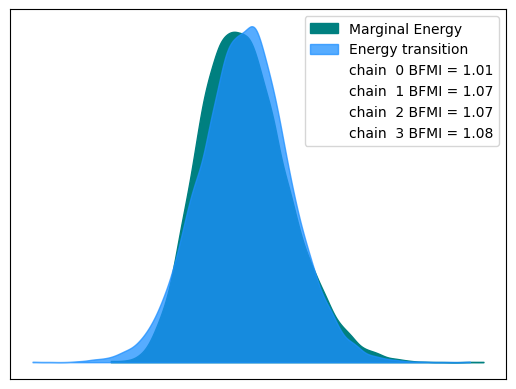

In [255]:
az.plot_energy(results)

In [256]:
az.summary(results)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
psi,0.923,0.013,0.899,0.948,0.000,0.000,20247.0,12554.0,1.0
Intercept,-1.516,4.243,-9.708,6.162,0.049,0.033,7638.0,9857.0,1.0
SURVEY_RANKED_EASTING,0.043,0.055,-0.061,0.149,0.000,0.000,16123.0,14304.0,1.0
SURVEY_RANKED_NORTHING,-0.061,0.093,-0.237,0.113,0.001,0.001,15343.0,14447.0,1.0
FISHED_AREA,-0.000,0.023,-0.043,0.043,0.000,0.000,20824.0,13517.0,1.0
AREA_DART,-0.023,3.288,-6.366,5.967,0.035,0.025,8802.0,11052.0,1.0
AREA_EXE,0.026,3.293,-6.234,6.094,0.035,0.025,8816.0,10874.0,1.0
AREA_PLYM,0.040,3.292,-6.106,6.278,0.035,0.025,8821.0,11117.0,1.0
AREA_TEIGN,-0.101,3.288,-6.358,5.958,0.035,0.025,8806.0,11181.0,1.0
SPECIES_SEA_TROUT,-0.034,2.695,-5.037,5.104,0.035,0.025,5964.0,8728.0,1.0


array([[<Axes: title={'center': 'psi'}>, <Axes: title={'center': 'psi'}>],
       [<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'Intercept'}>],
       [<Axes: title={'center': 'SURVEY_RANKED_EASTING'}>,
        <Axes: title={'center': 'SURVEY_RANKED_EASTING'}>],
       [<Axes: title={'center': 'SURVEY_RANKED_NORTHING'}>,
        <Axes: title={'center': 'SURVEY_RANKED_NORTHING'}>],
       [<Axes: title={'center': 'FISHED_AREA'}>,
        <Axes: title={'center': 'FISHED_AREA'}>],
       [<Axes: title={'center': 'AREA_DART'}>,
        <Axes: title={'center': 'AREA_DART'}>],
       [<Axes: title={'center': 'AREA_EXE'}>,
        <Axes: title={'center': 'AREA_EXE'}>],
       [<Axes: title={'center': 'AREA_PLYM'}>,
        <Axes: title={'center': 'AREA_PLYM'}>],
       [<Axes: title={'center': 'AREA_TEIGN'}>,
        <Axes: title={'center': 'AREA_TEIGN'}>],
       [<Axes: title={'center': 'SPECIES_SEA_TROUT'}>,
        <Axes: title={'center': 'SPECIES_SEA_TROUT'}>],


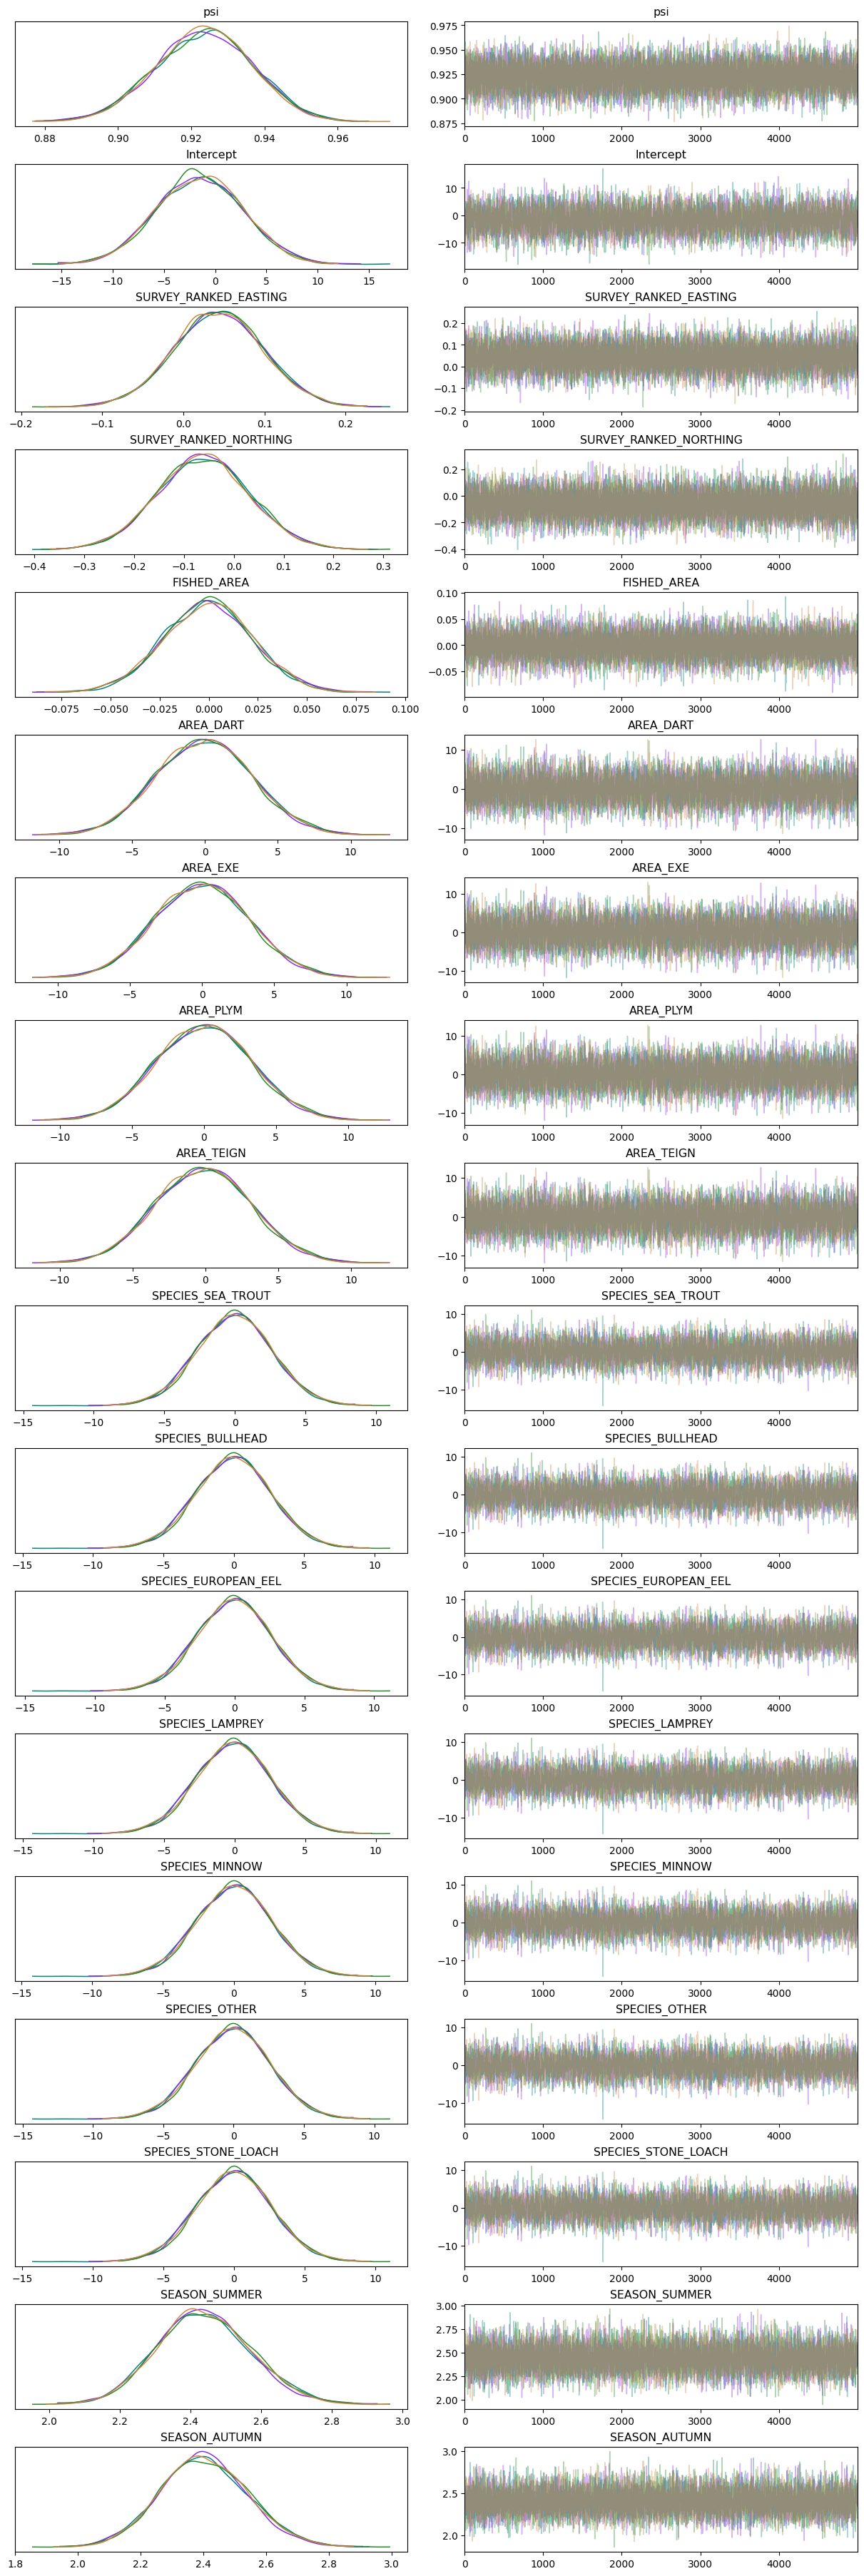

In [257]:
az.plot_trace(results, compact=False, backend_kwargs={"layout": "constrained"})

The Rhat statistic is 1.0 for all covariates, and the caterpillar plots for the markov chains look reasonable suggesting the model has converged.

Looking at the mean parameter estimates, the Dart and Exe typically have more fresh water fish than the Teign or Plym. Most species has a negative mean value, except for Minnow and Stone Loach. These fish are small and, clearly, are more commonly sampled. 

The sample method has a large impact on expected observed values. It might be worth experimenting with dropping some features. 

The event year has a negative mean parameter estimate, this may not be due to smaller stock but rather due to sample variance or the number of surveys per year. It may be worth dropping from the model too.

## Make Predictions

Here we make predictions on the TEST dataset by taking the mean estimate of `log observed` and transform it back to the original scale. We then compare it to the real value to estimate goodness-of-fit

In [258]:
test_preds = model.predict(idata=results,data=test,inplace=False,kind='response')

In [260]:
preds = test_preds['posterior_predictive'].to_dataframe().reset_index()

In [262]:
preds['OBSERVED'] = np.exp(preds['LOG_OBSERVED']-1)

In [279]:
mean_preds = np.floor(preds.groupby('__obs__')['OBSERVED'].mean())

In [280]:
test['PREDS'] = mean_preds

In [281]:
from sklearn.metrics import root_mean_squared_error

root_mean_squared_error(test['PREDS'],test['OBSERVED'])

17.469974241537965

In [282]:
test[['PREDS','OBSERVED']].head(20)

,PREDS,OBSERVED
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,20.0,113.0
5,0.0,0.0
6,0.0,0.0
7,0.0,0.0
8,0.0,0.0
9,0.0,0.0


The model is not totally unreasonable, but it could be better. The RMSE is 17 suggesting that on average it is out by 17 fish per sample. The model appears to predict low/zero counts well but struggles for species where there is a higher observed amount, this could be due to shrinkage of the parameter esitmates - a common problem in Bayesian regression models.

## Save Data

Here we save the data to CSV so that we can use it directly in the AutoML example without re-running our ingest and transform steps.

In [252]:
test.to_csv('./prepared_data/test.csv',index=False)

In [253]:
train.to_csv('./prepared_data/train.csv',index=False)